<a href="https://colab.research.google.com/github/johanhoffman/DD2365_VT24/blob/jengstrandj_lab3/Lab3/jengstrandj_lab3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **The Stokes equations - adaptive mesh refinement**
**Template by Johan Hoffman**

Edited by Josefin Engstrand Jonsson

# **Abstract**

In this report, we use FEniCS to solve the Stokes equations for two-dimensional flow past a circular obstacle. We define an adjoint problem with respect to a chosen linear functional and utilize it, together with the residual, to compute an error indicator used for adaptive mesh refinement. We study how moving the hole and modifying the data to the adjoint problem affects the adjoint solution and the subsequent mesh refinement. We find that the adjoint solution varies from configuration to configuration, but that the mesh is always refined near the obstacle or along the domain boundaries. Moreover, we confirm that an increased mesh resolution leads to a decreased total error, and that using the same approximation spaces for both the primal and the adjoint problem causes the total error to appear close to zero.

# **About the code**

In [ ]:
"""This program is an example file for the course"""
"""DD2365 Advanced Computation in Fluid Mechanics, """
"""KTH Royal Institute of Technology, Stockholm, Sweden."""

# Copyright (C) 2020 Johan Hoffman (jhoffman@kth.se)

# This file is part of the course DD2365 Advanced Computation in Fluid Mechanics
# KTH Royal Institute of Technology, Stockholm, Sweden
#
# This is free software: you can redistribute it and/or modify
# it under the terms of the GNU Lesser General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

# This template is maintained by Johan Hoffman
# Please report problems to jhoffman@kth.se

# **Set up environment**

In [145]:
# Load neccessary modules.
from google.colab import files

import numpy as np
import time

# Install FEniCS (this may take a long time)
try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install-real.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    import dolfin

from dolfin import *; from mshr import *

import dolfin.common.plotting as fenicsplot

from matplotlib import pyplot as plt

# **Introduction**

The Stokes equations take the form

$\nabla p -\Delta u = f,\quad \nabla \cdot u=0,$

together with boundary conditions for $\partial \Omega = \Gamma_D \cup \Gamma_N \cup \Gamma_F$

$
u=g_D,\quad x\in \Gamma_D
$

$
u=0,\quad x\in \Gamma_F
$

$
-\nabla u\cdot n + pn = 0,\quad x\in \Gamma_N
$

Here $\Gamma_D$ is the part of the boundary where we prescribe Dirichlet boundary conditions, $\Gamma_N$ a part of the boundary where we apply a homogeneous Neumann boundary condition, and $\Gamma_F$ the part of the boundary over which we want to compute the force.

The weak (variational) form of the equations is: find a solution $(u,p)\in V\times Q$ such that

$- (p,\nabla \cdot v) + (\nabla u,\nabla v) + (\nabla \cdot u, q) = (f,v)$

for all test functions $(v,q) \in \hat V \times Q$, where $\hat V$ are the test functions $v$ such that $v=0$ for $x\in \Gamma_D$.

Here we present a FEniCS implementation of a mixed finite element method to solve the Stokes equations in 2D. The solution is visualized using FEniCS plotting functions, and is also exported as pvd-files which can be visualized in Paraview.

We seek a finite element approximation $(U,P)\in V_h\times Q_h$ such that

$- (P,\nabla \cdot v) + (\nabla U,\nabla v) + (\nabla \cdot U, q) = (f,v)$

for all test functions $(v,q) \in \hat V_h \times Q_h$, where $\hat V_h$ are the test functions $v$ such that $v=0$ for $x\in \Gamma_D$. Here $V_h\subset V, Q_h\subset Q, \hat V_h\subset \hat V$ are finite dimensional subspaces defined over the computational mesh by finite element basis functions.

To implement the velocity Dirichlet boundary conditions we use a penalty formulation, with a penalty parameter $\gamma = C/h$, where $C>0$ is a constant and $h$ is the local mesh size. At the outflow a "do nothing" zero stress boundary condition is used, meaning that the boundary condition is enforced weakly by setting the boundary integral to zero.

We consider the linear functional $F:V\times Q\rightarrow {\mathbb R}$,

$F(v,q) = (v,\psi_1)_{\Omega} + (q,\psi_2)_{\Omega} + \left<\nabla v\cdot n - pn,\psi_3 \right>_{\Gamma_F}$

corresponding to weighted mean values of $v$ and $q$, and the force on the surface $\Gamma_F\subset \partial \Omega$, which generates the adjoint Stokes equations

$-\nabla \theta -\Delta \varphi = \psi_1,\quad -\nabla \cdot \varphi=\psi_2,$

together with boundary conditions that reflect the primal equations and the chosen functional.

$\varphi=0,\quad x\in \Gamma_D$

$\varphi=\psi_3,\quad x\in \Gamma_F$

$-\nabla \varphi \cdot n - \theta n=0, \quad x\in \Gamma_N$

The weak form of the adjoint Stokes equations take the form: find $(\varphi,\theta)\in \hat V\times Q$ such that

$- (q,\nabla \cdot \varphi) + (\nabla v,\nabla \varphi) + (\nabla \cdot v, \theta) = (v,\psi_1)_{\Omega} + (q,\psi_2)_{\Omega} - \left<\nabla v\cdot n - pn,\psi_3 \right>_{\Gamma_F}= F(v,q)$

for all test functions $(v,q) \in V\times Q$.

Since the Stokes equations are linear we can express the error in the linear functional with respect to an approximation $(u,p)\approx (U,P)$ as

$F(u,p) - F(U,P) = (f,\varphi) + (P,\nabla \cdot \varphi) - (\nabla U,\nabla \varphi) - (\nabla \cdot U, \theta) = r(U,P;\varphi,\theta) = \sum_K {\mathcal E}_K$

where we used that $F(u,p)=(f,\varphi)$ since $\varphi \in \hat V$,
with the error indicator

${\mathcal E}_K = r(U,P;\varphi,\theta)\vert _K$,

which is the local residual on weak form with the solution to the adjoint equation as test function. The error indicator ${\mathcal E}_K$ can be used as an indicator for where to refine the mesh to reduce the global error as efficiently as possible.

Note however that since $(U,P)\in V\times Q$ is the solution of a Galerkin finite element method, if we use the approximation $(\varphi,\theta) \approx (\varphi_h,\theta_h) \in \hat V_h\times Q_h$, the error indicators sum to zero. Hence, this sum cannot be used as a stopping criterion for an adaptive algorithm. Instead we may use error estimates of the type

$
{\mathcal E}_K \leq C h_K  (\Vert \nabla \varphi_h \Vert_K + \Vert \nabla \theta_h\Vert_K) \Vert R(U,P)\Vert_K
$

where $R(U,P)=(R_1(U,P),R_2(U))$ is the residual of the equations in strong form, with

$
R_1(U,P) = f + \Delta U - \nabla P
$

$
R_2(U) = \nabla \cdot U
$

To read more about how to use similar methods for more complex problems, see e.g.

[Hoffman, Johan, et al. "Towards a parameter-free method for high reynolds number turbulent flow simulation based on adaptive finite element approximation." Computer Methods in Applied Mechanics and Engineering 288 (2015): 60-74.](https://www.sciencedirect.com/science/article/pii/S0045782514004836)


# **Method**

**Define domain and mesh**

Our domain is a square channel with a circular hole of radius 0.2. In our experiments, we will move the hole across the domain: from the left boundary to the middle, then to the right boundary, and finally to the bottom right corner. We will also test different mesh resolutions ($h=1/16$, $h=1/32$ and $h=1/64$) to confirm that an improved resolution leads to a lower total error.

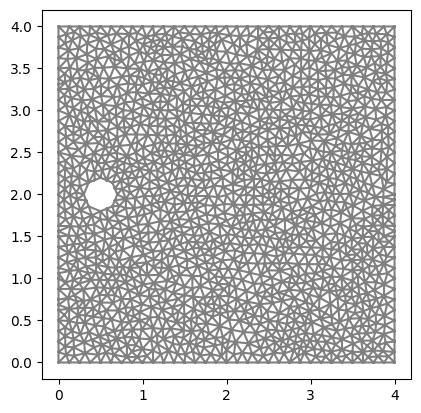

In [146]:
# Define a square domain
L = 4
H = 4

# Define circle
(xc, yc) = (0.5, 0.5*H)  # Left boundary
#(xc, yc) = (0.5*L, 0.5*H)  # Middle
#(xc, yc) = (3.5, 0.5*H)  # Right boundary
#(xc, yc) = (3.5, 0.5)  # Bottom right corner
rc = 0.2

# Generate a mesh with a circular hole
#resolution = 64
resolution = 32
#resolution = 16
mesh = generate_mesh(Rectangle(Point(0.0,0.0), Point(L,H)) - Circle(Point(xc,yc),rc), resolution)

plt.figure()
plot(mesh)
plt.show()

**Define finite element approximation spaces**

For the primal problem, we use quadratic approximation of the velocity and linear approximation of the pressure. The approximation spaces for the adjoint problem will be of one degree higher. Later, we will also test using the same approximation spaces for both the primal and the adjoint problem to confirm that this (wrongly) leads to a zero total error.

In [147]:
# Generate mixed finite element spaces (for primal velocity and pressure)
VE = VectorElement("CG", mesh.ufl_cell(), 2)
QE = FiniteElement("CG", mesh.ufl_cell(), 1)
WE = VE * QE

W = FunctionSpace(mesh, WE)
V = FunctionSpace(mesh, VE)
Q = FunctionSpace(mesh, QE)

# Define trial and test functions
w = Function(W)
(u, p) = (as_vector((w[0],w[1])), w[2])
(v, q) = TestFunctions(W)

# Generate mixed finite element spaces (for adjoint velocity and pressure)
VEa = VectorElement("CG", mesh.ufl_cell(), 3)
QEa = FiniteElement("CG", mesh.ufl_cell(), 2)

# This mixed finite element space should (wrongly) give an error of zero
#VEa = VectorElement("CG", mesh.ufl_cell(), 2)
#QEa = FiniteElement("CG", mesh.ufl_cell(), 1)

WEa = VEa * QEa
Wa = FunctionSpace(mesh, WEa)
Va = FunctionSpace(mesh, VEa)
Qa = FunctionSpace(mesh, QEa)

# Define adjoint trial and test functions
wa = Function(Wa)
(phi, theta) = (as_vector((wa[0],wa[1])), wa[2])
(va, qa) = TestFunctions(Wa)

**Define boundary conditions**

In [148]:
# Inflow and outflow conditions
XMIN = 0.0; XMAX = L
YMIN = 0.0; YMAX = H
uin = Expression(("4*(x[1]*(YMAX-x[1]))/(YMAX*YMAX)", "0."), YMAX=YMAX, element = V.ufl_element())

# Inflow boundary (ib), outflow boundary (ob), body boundary (bb) and wall boundary (wb)
ib = Expression("near(x[0],XMIN) ? 1. : 0.", XMIN=XMIN, element = Q.ufl_element())
ob = Expression("near(x[0],XMAX) ? 1. : 0.", XMAX=XMAX, element = Q.ufl_element())
wb = Expression("near(x[1],YMIN) || near(x[1],YMAX) ? 1. : 0.", YMIN=YMIN, YMAX=YMAX, element = Q.ufl_element())
bb = Expression("x[0] > XMIN + DOLFIN_EPS && x[0] < XMAX - DOLFIN_EPS && x[1] > YMIN + DOLFIN_EPS && x[1] < YMAX - DOLFIN_EPS ? 1. : 0.", XMIN=XMIN, XMAX=XMAX, YMIN=YMIN, YMAX=YMAX, element = Q.ufl_element())

# **Results**

**Define and solve variational problems**

Define the primal problem:

In [149]:
# Set boundary penalty parameter gamma
h = CellDiameter(mesh)
C = 1.0e3
gamma = C/h

# Set force in primal problem
f = Expression(("0.0","0.0"), element = V.ufl_element())

# Define primal variational problem on residual form: r(u,p;v,q) = 0
res = ( -p*div(v)*dx + inner(grad(u), grad(v))*dx + div(u)*q*dx - inner(f, v)*dx +
        gamma*(ib*inner(u - uin, v) + wb*inner(u, v) + bb*inner(u, v))*ds )

# Solve primal algebraic system
solve(res == 0, w)

Define the adjoint problem. We will try different functionals, corresponding to
- the drag force: $\psi_1=(0, 0), \psi_2=0, \psi_3=(1,0)$,
- the lift force: $\psi_1=(0, 0), \psi_2=0, \psi_3=(0,1)$,
- the horizontal velocity: $\psi_1=(1,0),\psi_2=0, \psi_3=(0,0)$,
- the pressure: $\psi_1=(0,0),\psi_2=1,\psi_3=(0,0)$.

In [150]:
# Set data that describe functional that defines the adjoint problem
# Drag force
psi1 = Expression(("0.0","0.0"), element = V.ufl_element())
psi2 = Expression("0.0", element = Q.ufl_element())
psi3 = Expression(("1.0","0.0"), element = V.ufl_element())

# Lift force
#psi1 = Expression(("0.0","0.0"), element = V.ufl_element())
#psi2 = Expression("0.0", element = Q.ufl_element())
#psi3 = Expression(("0.0","1.0"), element = V.ufl_element())

# Horizontal velocity
#psi1 = Expression(("1.0","0.0"), element = V.ufl_element())
#psi2 = Expression("0.0", element = Q.ufl_element())
#psi3 = Expression(("0.0","0.0"), element = V.ufl_element())

# Pressure
#psi1 = Expression(("0.0","0.0"), element = V.ufl_element())
#psi2 = Expression("1.0", element = Q.ufl_element())
#psi3 = Expression(("0.0","0.0"), element = V.ufl_element())

# Define adjoint variational problem on residual form: r(u,p;v,q) = 0
res_a = ( -qa*div(phi)*dx + inner(grad(va), grad(phi))*dx + div(va)*theta*dx +
          gamma*(ib*inner(phi, va) + wb*inner(phi, va) + bb*inner(phi - psi3, va))*ds
         - inner(va, psi1)*dx - qa*psi2*dx )

# Solve adjoint algebraic system
solve(res_a == 0, wa)

**Visualize solution and export files**

rm: cannot remove 'results-NS/*': No such file or directory


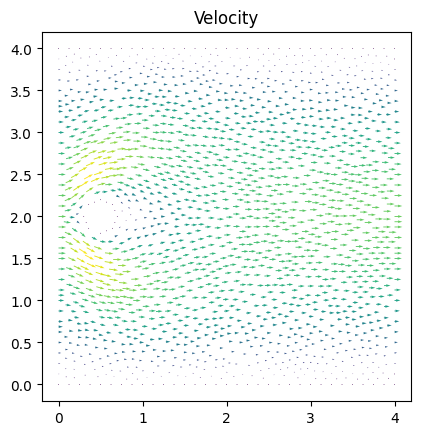

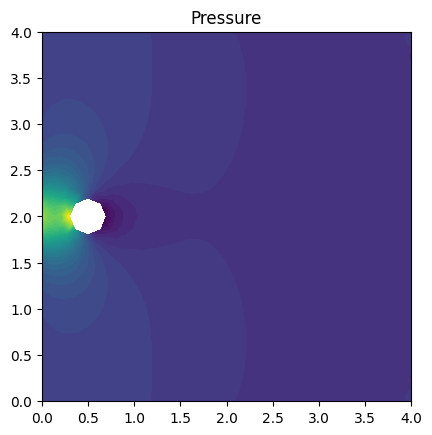

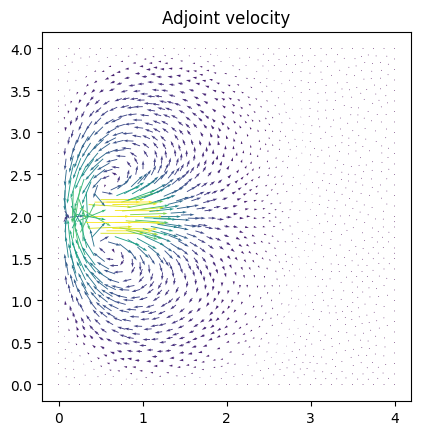

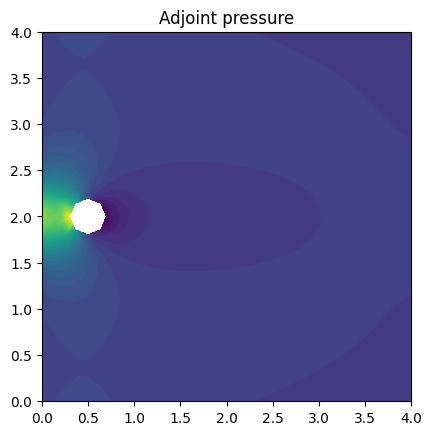

In [151]:
!rm results-NS/*

# Open files to export solution to Paraview
file_u = File("results-Stokes/u.pvd")
file_p = File("results-Etokes/p.pvd")
file_phi = File("results-Stokes/phi.pvd")
file_theta = File("results-Etokes/theta.pvd")

# Initiate functions to save and visualize the solutions
u_fcn = project(u, V)
p_fcn = project(p, Q)
phi_fcn = project(phi, V)
theta_fcn = project(theta, Q)

# Save solution to file
file_u << u_fcn
file_p << p_fcn
file_phi << phi_fcn
file_theta << theta_fcn

# Plot solution
plt.figure()
plot(u_fcn, title="Velocity")

plt.figure()
plot(p_fcn, title="Pressure")

plt.figure()
plot(phi_fcn, title="Adjoint velocity")

plt.figure()
plot(theta_fcn, title="Adjoint pressure")

#plt.show()

# Export files
#!tar -czvf results-Stokes.tar.gz results-NS
#files.download('results-Stokes.tar.gz')

**Compute error indicators**

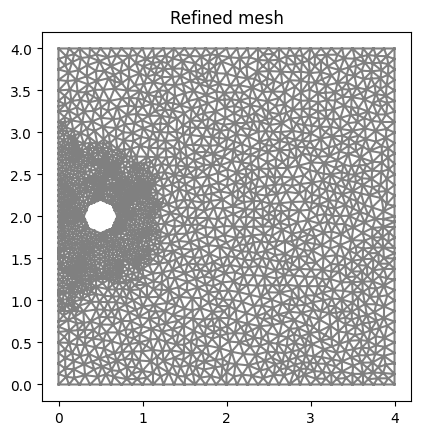

Total error = 0.050622244947699326


In [152]:
# Define function space over the elements of the mesh
WDG = FunctionSpace(W.mesh(), "DG", 0)
elm = TestFunction(WDG)
err_ind = Function(WDG)

# Compute local error indicators over the cells of the mesh
local_error = ( elm*inner(f, phi)*dx + elm*p*div(phi)*dx - elm*inner(grad(u), grad(phi))*dx - elm*div(u)*theta*dx )
err_ind.vector()[:] = assemble(local_error)
err_ind_abs = np.abs(err_ind.vector())
err_ind_mean = err_ind_abs.sum()/err_ind.vector().size()

# Local mesh refinement (specified by a cell marker)
no_levels = 1
for i in range(0,no_levels):
  cell_marker = MeshFunction("bool", mesh, mesh.topology().dim())
  for c in cells(mesh):
    cell_marker[c] = False
    local_error_cell = err_ind_abs[c.index()]
    if local_error_cell > err_ind_mean:
        cell_marker[c] = True
  mesh = refine(mesh, cell_marker)

plt.figure()
plot(mesh)
plt.title("Refined mesh")
plt.show()

err_ind_sum = ( inner(f, phi)*dx + p*div(phi)*dx - inner(grad(u), grad(phi))*dx - div(u)*theta*dx -
               gamma*(ib*inner(u - uin, phi) + wb*inner(u, phi) + bb*inner(u, phi))*ds )

tot_err = assemble(err_ind_sum)
s = 'Total error = ' + repr(tot_err)
print(s)

**Baseline for comparison**

We use the code above to study how the adjoint solution and the refined mesh change as we move the hole and modify the functional. Our baseline for comparison will be the solution for a hole with center at $(0.5, 2)$, obtained by defining the functional equal to the drag force ($\psi_1=(0, 0), \psi_2=0, \psi_3=(1,0)$). As seen in the images below, the adjoint velocity and pressure behave almost as if they were real velocities and pressures. The adjoint velocity field emanates from the edges of the hole and forms two vortices that circle back to the origin. The adjoint pressure peaks upstream of the hole, but then drops to low values quickly. The mesh is refined only near the hole.

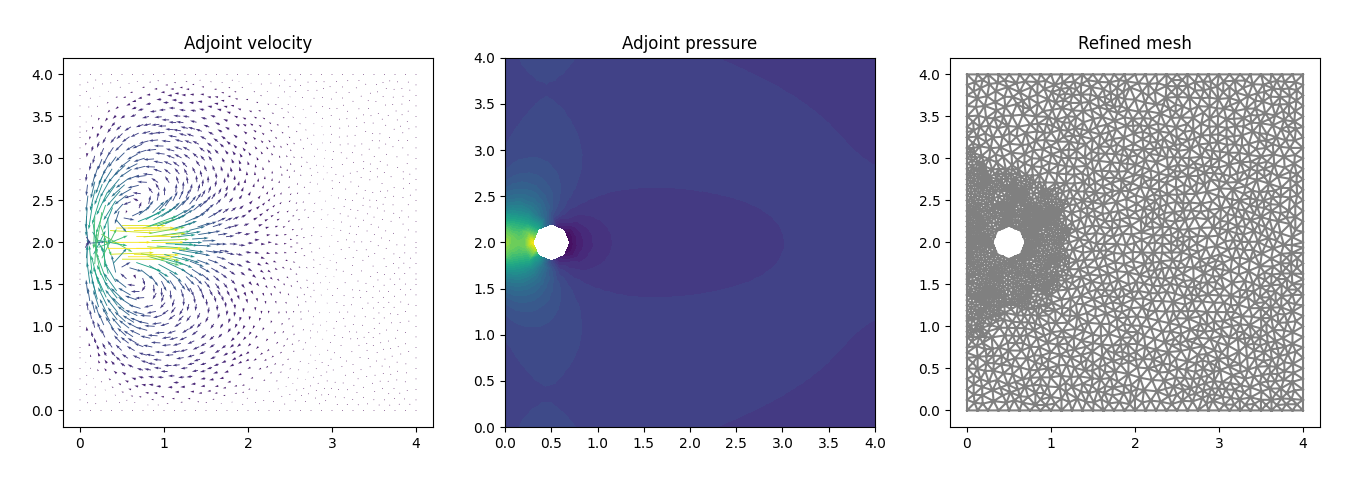

**Effect of moving the hole across the domain**

With the hole center at $(2, 2)$, we obtain the images below. The adjoint velocity looks similar to the baseline solution. The field still emanates from the hole edges, but the two vortices are now even more apparent. The adjoint pressure still reaches its highest values upstream of the hole, but the subsequent drop to lower values is not as drastic as before. The mesh is still refined near the hole, but interestingly enough it is also refined near the two wall boundaries.

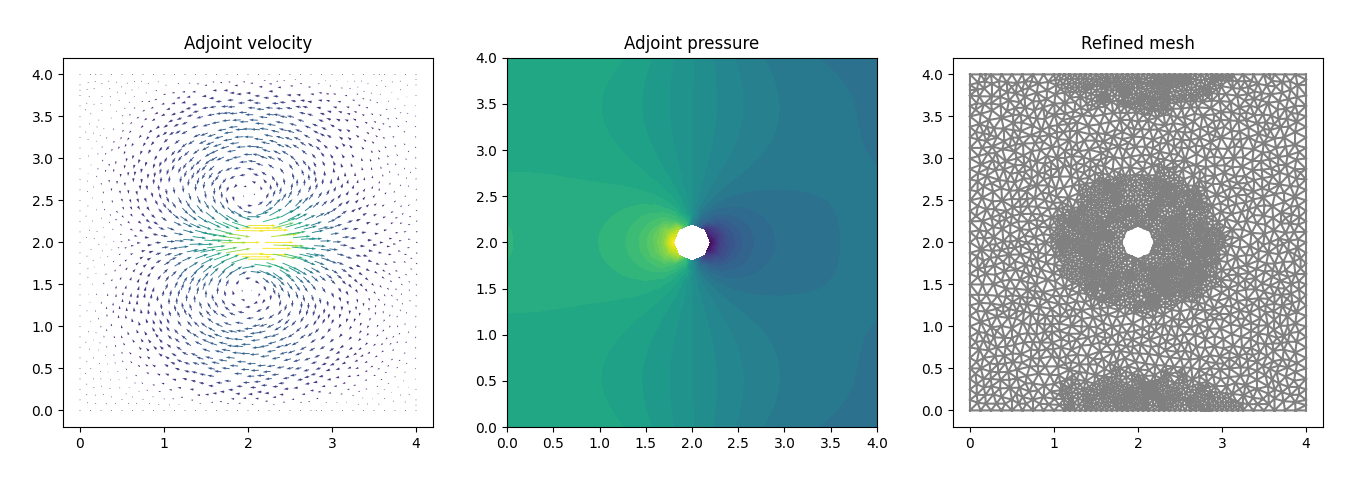

The following plots show the results for the hole center at $(3.5, 2)$. The adjoint velocity field has more or less been translated in the horizontal direction. The adjoint pressure is constant in the first half of the domain and then changes analogously to what has been described before. The mesh is refined around the circle, but also in the top and bottom right corners of the domain.

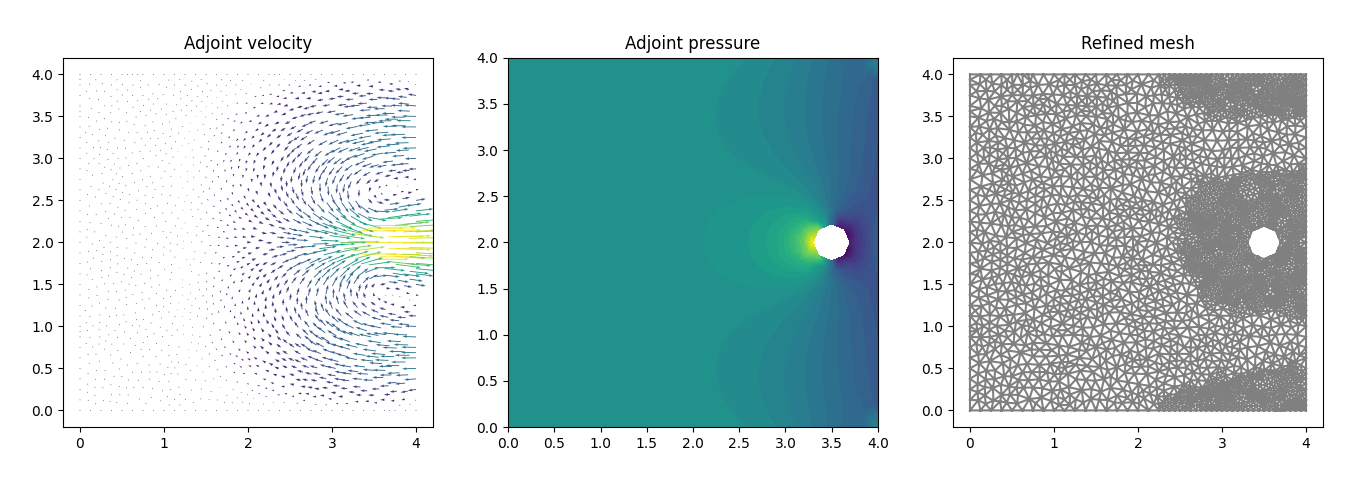

Finally, with the hole centered at $(3.5, 0.5)$, we can only observe one vortex in the adjoint velocity field. The adjoint pressure mainly changes in the bottom right corner. The mesh is refined near the hole and the lower wall boundary, but also in the top right corner of the domain. Notice that there is a small area in the bottom right corner that is not refined despite its close proximity to the hole and the boundaries.

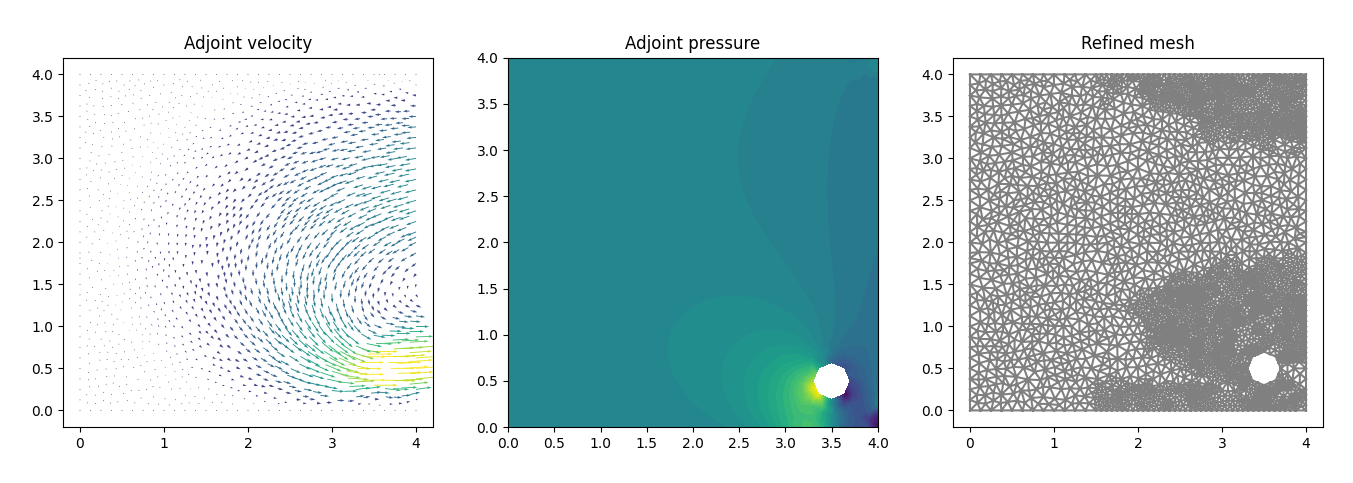

**Effect of changing the functional**

Using the functional corresponding to the lift force, i.e. choosing $\psi_1=(0, 0)$, $\psi_2=0$ and $\psi_3=(1, 0)$, we obtain the plots below. The adjoint velocity moves in an almost circular manner, with its source again being the hole boundary. The adjoint pressure reaches its maximum just below the hole, and its maximum just above, i.e., not upstream and downstream as in the baseline solution. The mesh is refined near the hole, but also along parts of the top and bottom wall boundaries as well as sections inbetween.

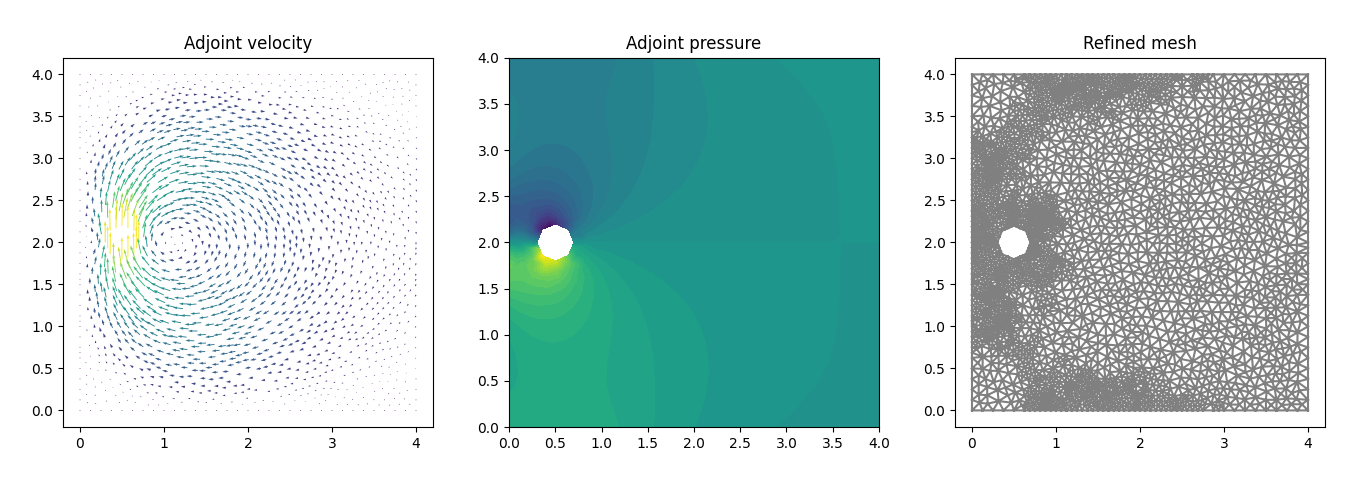

Defining the functional equal to the horizontal velocity, i.e., letting $\psi_1 = (1, 0)$, $\psi_2 = 0$ and $\psi_3 = (0, 0)$, we obtain the solution below. The adjoint velocity is almost horizontal at outflow, where it reaches its highest values. The adjoint pressure is constant in the vertical direction but decreases linearly in the horizontal direction. The mesh is refined close to the hole as well as in the top and bottom left corners of the domain.

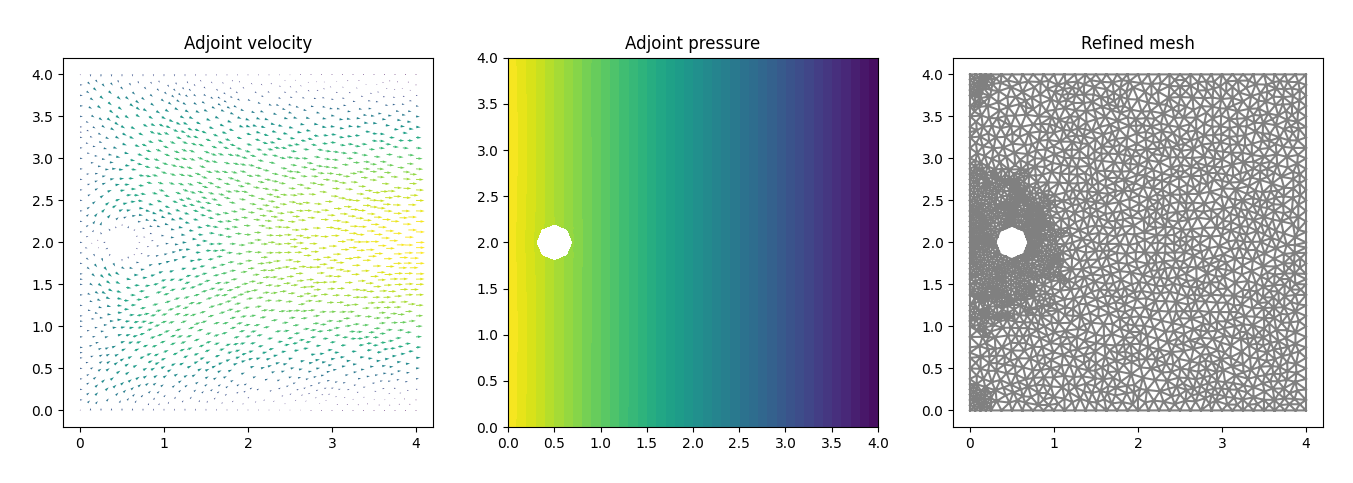

Finally, with the pressure functional, i.e., $\psi_1=(0, 0)$, $\psi_2=1$, $\psi_3=(0, 0)$, we get the following results. The adjoint velocity flows from the right to the left, and mainly has a horizontal component. The adjoint pressure unexpectedly increases in the four corners of the domain. The mesh is refined along the left, top and bottom boundaries, to a much greater extent than seen previously.

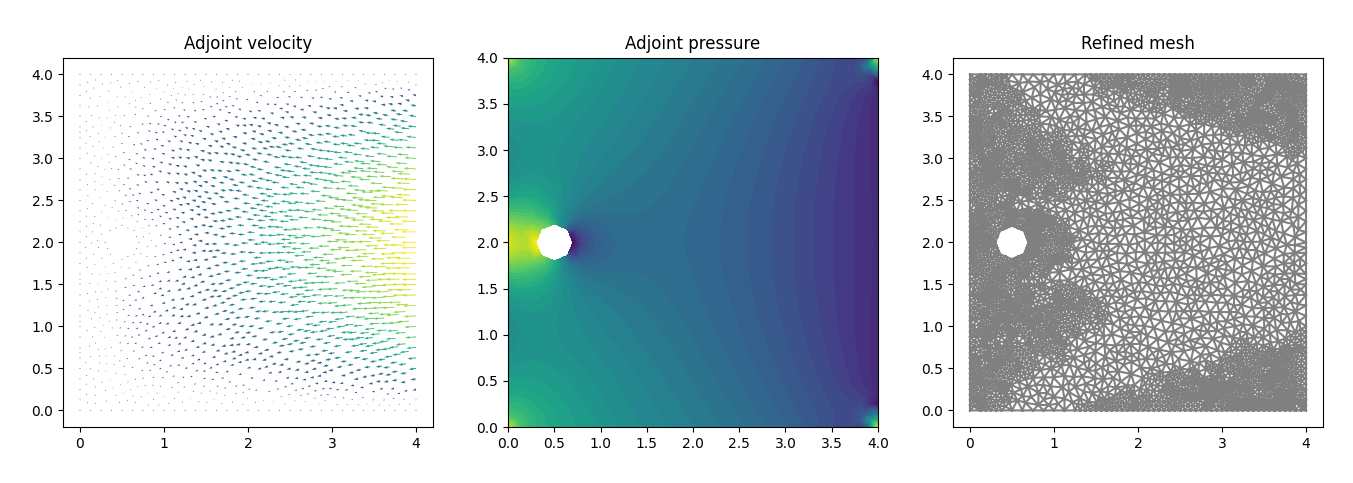

**Dependence of the total error on the mesh resolution and approximation spaces**

At last, we study the total error. Testing our code using three different meshes, we obtain the total errors in the table below. As expected, the error decreases when the mesh resolution increases.

| Resolution | Total error |
| ---------- | ----------- |
| 1/16 | 0.3573  |
| 1/32 | 0.0506  |
| 1/64 | -0.0023 |

All results up until now, including those in the table above, have been obtained using quadratic and linear approximations of the velocity and pressure, respectively, and cubic and quadratic approximations of the adjoint velocity and adjoint pressure, respectively. If we instead use the same quadratic approximation space for both the primal and adjoint velocity, and the same linear approximation space for both the primal and adjoint pressure, we arrive at the (faulty) conclusion that the error is $-2.0248\cdot10^{-13}$ when $h=1/32$, i.e., almost zero. This was also anticipated from theory.


# **Discussion**

An adaptive finite element method was implemented in FEniCS to solve the 2D Stokes equations for flow past a circular obstacle. An adjoint problem was defined with respect to a chosen linear functional, after which the residual and the solution to the adjoint was used to define an error indicator over the mesh. The effect of moving the obstacle across the domain on the adjoint solution and the mesh refinement was studied. The mesh was always refined near the obstacle, a logical conclusion since this was where the solution changed the most. Interestingly, the mesh was also refined along the domain boundaries, but the reason why was not clear. The effect of modifying the functional was also studied. Depending on the functional, different parts of the mesh were refined and to different extents. This suggests that one should put some thought into which functional to choose for the particular problem considered, as this could lead to an overly or underly refined mesh. It was also confirmed that the total error is reduced when using an increasingly finer mesh. Finally, it was verified that the error is near-zero when using the same approximation spaces for both the primal and adjoint problem.